
# NLP: Predicciendo la polaridad de reseñas usando Deep Learning

La importancia de la satisfacción del cliente radica en que nos ayuda a saber la probabilidad de que un cliente haga una compra a futuro. Pedir a los clientes que califiquen el grado de satisfacción es una buena forma de ver si se convertirán en clientes habituales o incluso en defensores de la marca.

En el presente proyecto crearemos un modelo de Machine Learning que predica el número de estrellas que recibiría un producto con base en el comentario que haya dejado un cliente. Para ello utilizaremos el dataset de reseñas de Amazon en español. 

<div class="alert alert-warning">
<b>The Multilingual Amazon Reviews Corpus</b> <br>
Se puede acceder al dataset <a href="https://drive.google.com/uc?export=download&id=11XnXB7Ubgf3t6gotXGlM4FCwPOMHhDLX">aquí</a>. Es un comprimido .zip que contiene tres archivos .json. Más información sobre el dataset <a href="https://registry.opendata.aws/amazon-reviews-ml/">aquí</a>. Es importante que tengas en cuenta la <a href="https://docs.opendata.aws/amazon-reviews-ml/license.txt">licencia</a> de este dataset.
</div>

<a id="2.1"></a>
## Importaciones y configuración 

Importamos las librerías necesarias

In [3]:
''' Data manipulation '''
import numpy as np
import pandas as pd

'''Stats'''
from scipy.sparse import csr_matrix, hstack

''' Visualization '''
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

''' NLP '''
import re
import nltk


''' Machine Learning '''
# Preprocessing 
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
# Models
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
# Selec
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

''' Misc '''
import gc 
from time import time

Configuramos el estilo de los gráficos

In [4]:
from matplotlib.colors import LinearSegmentedColormap

# Palette
blue = '#146EF5'
red = '#ED3767'
amber = '#F5B14C'
mint = '#17BED1'
purple = '#815ADB'
pink = '#FE90AD'

# Cualitative colormap
palette = [blue, red, pink, purple, amber, mint]

# Sequential colormap
bluemint = LinearSegmentedColormap.from_list("myBlues", [mint, blue])
redpink = LinearSegmentedColormap.from_list("myReds", [pink, red])
redwhite = LinearSegmentedColormap.from_list("myReds", ['white', red])
bluewhite = LinearSegmentedColormap.from_list("myReds", ['white', blue])

# Diverging colormap
bluered = LinearSegmentedColormap.from_list("myBlueRed", [red, "white", blue])
blupurred = LinearSegmentedColormap.from_list("myBlueRed", [red, purple, blue])
rainbow = LinearSegmentedColormap.from_list("myBlueRed", [pink, red, purple, blue, mint])

params = {'axes.edgecolor': '0.9', 'axes.labelcolor': '0.4',
          'text.color': '0.3', 'xtick.color': '0.5', 'ytick.color': '0.5',
          'font.size': 16, 'axes.titlesize': 16, 'axes.labelsize': 12,
          'xtick.labelsize': 12, 'ytick.labelsize': 12,
          'figure.figsize': (9, 6), 'axes.spines.right': False, 'axes.spines.top': False}

sns.set(context='notebook', style='white', palette=palette,
        font='Gadugi', rc=params)

<a id="2.2"></a>
## 2.2 Carga de datos y preprocesado

Cargamos los datos

In [5]:
train = pd.read_csv('/work/processed_data/train.csv')
dev = pd.read_csv('/work/processed_data/dev.csv')
test = pd.read_csv('/work/processed_data/test.csv')

In [6]:
X_train = train[['full_text', 'clean_text']].copy()
X_dev = dev[['full_text', 'clean_text']].copy()
X_test = test[['full_text', 'clean_text']].copy()

In [105]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=100, dtype=np.float32)

train_ngrams =  vectorizer.fit_transform(X_train['clean_text'])
dev_ngrams = vectorizer.transform(X_dev['clean_text'])
test_ngrams = vectorizer.transform(X_test['clean_text'])

# Obtenemos los nombres de las features
features_ngrams = np.array(vectorizer.get_feature_names())

Ahora extraemos las features indirectas:
mean_word_len,
count_stopwords,
word_unique_percent,
count_word, count_letters,
count_unique_word.

In [106]:
stopword_list = nltk.corpus.stopwords.words('spanish')

In [107]:
train_indirect = pd.DataFrame()
train_indirect['count_word'] = X_train['full_text'].apply(lambda x: len(str(x).split()))
train_indirect['count_letters'] = X_train['full_text'].apply(lambda x: len(str(x)))
train_indirect['count_unique_word'] = X_train['full_text'].apply(lambda x: len(set(str(x).split())))
train_indirect["count_stopwords"] = X_train["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword_list]))
train_indirect["mean_word_len"] = X_train["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
train_indirect['word_unique_percent'] = train_indirect['count_unique_word']*100/train_indirect['count_word']

In [108]:
dev_indirect = pd.DataFrame()
dev_indirect['count_word'] = X_dev['full_text'].apply(lambda x: len(str(x).split()))
dev_indirect['count_letters'] = X_dev['full_text'].apply(lambda x: len(str(x)))
dev_indirect['count_unique_word'] = X_dev['full_text'].apply(lambda x: len(set(str(x).split())))
dev_indirect["count_stopwords"] = X_dev["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword_list]))
dev_indirect["mean_word_len"] = X_dev["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
dev_indirect['word_unique_percent'] = dev_indirect['count_unique_word']*100/dev_indirect['count_word']

In [109]:
test_indirect = pd.DataFrame()
test_indirect['count_word'] = X_test['full_text'].apply(lambda x: len(str(x).split()))
test_indirect['count_letters'] = X_test['full_text'].apply(lambda x: len(str(x)))
test_indirect['count_unique_word'] = X_test['full_text'].apply(lambda x: len(set(str(x).split())))
test_indirect["count_stopwords"] = X_test["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword_list]))
test_indirect["mean_word_len"] = X_test["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_indirect['word_unique_percent'] = test_indirect['count_unique_word']*100/test_indirect['count_word']

Leemos los datasets de polaridad

In [110]:
train_polarity = pd.read_csv('processed_data/train_polarity.csv')
dev_polarity = pd.read_csv('processed_data/dev_polarity.csv')
test_polarity = pd.read_csv('processed_data/test_polarity.csv')

Solo falta juntar todas las features en un matriz dispersa

In [111]:
X_train = hstack((train_ngrams, train_indirect,  train_polarity)).tocsr()
X_dev = hstack((dev_ngrams, dev_indirect,  dev_polarity)).tocsr()
X_test = hstack((test_ngrams, test_indirect,  test_polarity)).tocsr()

*target y*

In [112]:
y_train = train['stars'].values
y_dev = dev['stars'].values
y_test = test['stars'].values

*target y* multilabel

In [113]:
# Train 
y_train_multi = pd.DataFrame(data=np.zeros((train.shape[0], 5)).astype(int), columns=[1, 2, 3, 4, 5])
for i in range(5):
    y_train_multi.iloc[:, i] = np.array(train.stars == i+1).astype(int)
    
# Dev
y_dev_multi = pd.DataFrame(data=np.zeros((dev.shape[0], 5)).astype(int), columns=[1, 2, 3, 4, 5])
for i in range(5):
    y_dev_multi.iloc[:, i] = np.array(dev.stars == i+1).astype(int)

# Test
y_test_multi = pd.DataFrame(data=np.zeros((test.shape[0], 5)).astype(int), columns=[1, 2, 3, 4, 5])
for i in range(5):
    y_test_multi.iloc[:, i] = np.array(test.stars == i+1).astype(int)

<a id="3.2.1"></a>
### 3.2.1 Benchmark

Nuestro modelo de comparación será un clasificador tonto: predice aleatoriamente los valores de la lcases teniendo en cuenta su distribución en el set de entrenamiento.

In [114]:
benchmark = DummyClassifier(strategy='prior')
benchmark.fit(X_train, y_train)

DummyClassifier(strategy='prior')

In [115]:
y_train_pred_bench = benchmark.predict(X_train)
y_dev_pred_bench = benchmark.predict(X_dev)
y_test_pred_bench = benchmark.predict(X_test)

print('Accuracy en el set de Train:', accuracy_score(y_train, y_train_pred_bench))
print('Accuracy en el set de Dev:', accuracy_score(y_dev, y_dev_pred_bench))
print('Accuracy en el set de Test:', accuracy_score(y_test, y_test_pred_bench), '<---')

Accuracy en el set de Train: 0.2
Accuracy en el set de Dev: 0.2
Accuracy en el set de Test: 0.2 <---


<a id="3.2.1"></a>
### 3.2.1 NBSVM

Para el modelo final usaremos NBSVM (Naive Bayes - Support Vector Machine). El algoritmo fue presentado por Sida Wang y Chris Manning en el artículo [Baselines and Bigrams: Simple, Good Sentiment and Topic Classiﬁcation](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf).

Cretidos a [AlexSanchez](https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline-eda-0-052-lb#261316) por la implementación en python para la competición de Kaggle, *Toxic Comment Classification Challenge*.

In [116]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted

In [117]:
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))
                            
    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

In [118]:
stars = [1, 2, 3, 4, 5]

# Métricas
auc_train = []
auc_dev = []
auc_test = []

# Predcciones de probabilidades
y_train_pred_prob = np.zeros((X_train.shape[0], y_train_multi.shape[1]))
y_dev_pred_prob = np.zeros((X_dev.shape[0], y_dev_multi.shape[1]))
y_test_pred_prob = np.zeros((X_test.shape[0], y_test_multi.shape[1]))

for i, j in enumerate(stars):
    print ('Estrella {}'.format(i+1))
    
    #Entrenamos
    nbsvm = NbSvmClassifier(C=4, dual=False, n_jobs=-1)
    nbsvm.fit(X_train, y_train_multi.iloc[:, i]) 
    
    #Predecimos la probabilidad
    y_train_pred_prob[:, i] = nbsvm.predict_proba(X_train)[:, 1]
    y_dev_pred_prob[:, i] = nbsvm.predict_proba(X_dev)[:, 1]
    y_test_pred_prob[:, i] = nbsvm.predict_proba(X_test)[:, 1]
    
    #Hallamos el área bajo la curva de cada estrella
    auc_train_star = roc_auc_score(y_train_multi[j], y_train_pred_prob[:, i])
    auc_dev_star = roc_auc_score(y_dev_multi[j], y_dev_pred_prob[:, i])
    auc_test_star = roc_auc_score(y_test_multi[j], y_test_pred_prob[:, i])   
    
    print('ROC-AUC en train: {:.3f}'.format(auc_train_star))
    print('ROC-AUC en dev: {:.3f}'.format(auc_dev_star))
    print('ROC-AUC en test: {:.3f} <--'.format(auc_test_star))
    
    auc_train.append(auc_train_star)
    auc_dev.append(auc_dev_star)
    auc_test.append(auc_test_star)
    print('='*60)

print()
print('ROC-AUC promedio en el set de Train:', np.mean(auc_train))
print('ROC-AUC promedio en el set de Dev:', np.mean(auc_dev))
print('ROC-AUC promedio en el set de Test:', np.mean(auc_test), '<---')

Estrella 1
ROC-AUC en train: 0.931
ROC-AUC en dev: 0.929
ROC-AUC en test: 0.930 <--
Estrella 2
ROC-AUC en train: 0.787
ROC-AUC en dev: 0.777
ROC-AUC en test: 0.785 <--
Estrella 3
ROC-AUC en train: 0.764
ROC-AUC en dev: 0.749
ROC-AUC en test: 0.771 <--
Estrella 4
ROC-AUC en train: 0.794
ROC-AUC en dev: 0.786
ROC-AUC en test: 0.799 <--
Estrella 5
ROC-AUC en train: 0.897
ROC-AUC en dev: 0.891
ROC-AUC en test: 0.893 <--

ROC-AUC promedio en el set de Train: 0.8346664331874999
ROC-AUC promedio en el set de Dev: 0.82650515
ROC-AUC promedio en el set de Test: 0.8356419500000001 <---


In [119]:
y_train_pred_nbsvm = pd.DataFrame(data=y_train_pred_prob, columns=stars).idxmax(axis=1)
y_dev_pred_nbsvm = pd.DataFrame(data=y_dev_pred_prob, columns=stars).idxmax(axis=1)
y_test_pred_nbsvm = pd.DataFrame(data=y_test_pred_prob, columns=stars).idxmax(axis=1)

print('Accuracy en el set de Train:', accuracy_score(y_train, y_train_pred_nbsvm))
print('Accuracy en el set de Dev:', accuracy_score(y_dev, y_dev_pred_nbsvm))
print('Accuracy en el set de Test:', accuracy_score(y_test, y_test_pred_nbsvm), '<---')

Accuracy en el set de Train: 0.54818
Accuracy en el set de Dev: 0.5394
Accuracy en el set de Test: 0.5526 <---


<a id="3.2.2"></a>
### 3.2.2 Linear SVC

In [120]:
svc = LinearSVC(penalty='l2', dual=False, tol=1e-4, C=0.01)

In [121]:
svc.fit(X_train, y_train)

LinearSVC(C=0.01, dual=False)

In [122]:
y_train_pred_svc = svc.predict(X_train)
y_dev_pred_svc = svc.predict(X_dev)
y_test_pred_svc = svc.predict(X_test)

print('Accuracy en el set de Train:', accuracy_score(y_train, y_train_pred_svc))
print('Accuracy en el set de Dev:', accuracy_score(y_dev, y_dev_pred_svc))
print('Accuracy en el set de Test:', accuracy_score(y_test, y_test_pred_svc), '<---')

Accuracy en el set de Train: 0.55781
Accuracy en el set de Dev: 0.544
Accuracy en el set de Test: 0.5552 <---


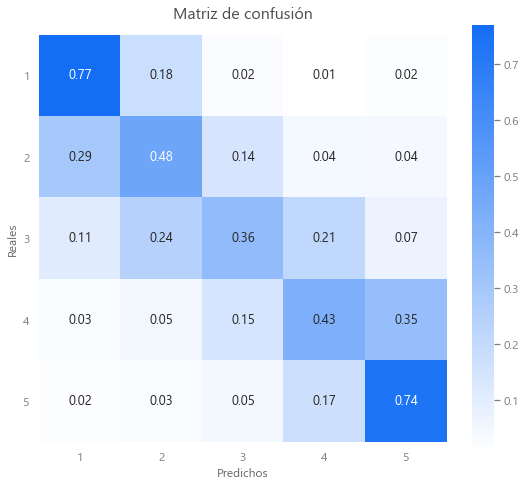

In [123]:
plt.figure(figsize=(8, 7))
conf_sent = confusion_matrix(y_test, y_test_pred_svc, 
                             labels=[1, 2, 3, 4, 5], 
                             normalize='true')
sns.heatmap(data = conf_sent, cbar=True, square=True, annot=True, 
            fmt= '.2f', annot_kws={'size': 13}, 
            xticklabels = [1, 2, 3, 4, 5], 
            yticklabels = [1, 2, 3, 4, 5], 
            cmap=bluewhite)

plt.title('Matriz de confusión', pad=16)
plt.ylabel('Reales')
plt.xlabel('Predichos')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

## 3.3 Resultados

In [124]:
# Creamos el DataFrame de los coeficientes
columns = np.concatenate((features_ngrams, train_indirect.columns, train_polarity.columns))
coeff = svc.coef_
coeff_svc = pd.DataFrame(coeff, columns=columns, index=[1, 2, 3, 4, 5])
mean_coeff_column = coeff_svc.mean().abs().sort_values(ascending=False)[:15]

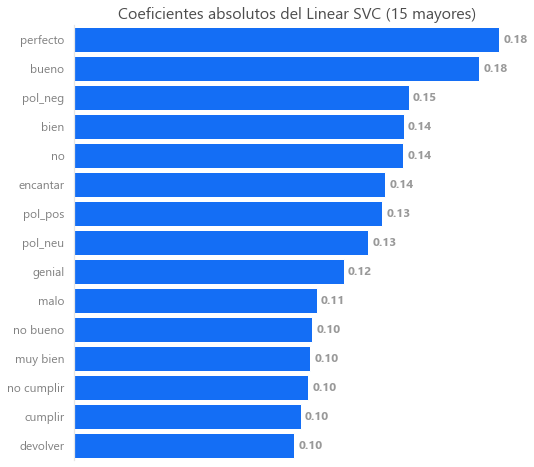

In [125]:
# Graficamos
plt.figure(figsize=(8, 8))
ax = sns.barplot(x=mean_coeff_column.values, 
                 y=mean_coeff_column.index,
                 color=blue, 
                 orient='h', 
                 saturation=1)
ax.set_title('Coeficientes absolutos del Linear SVC (15 mayores)')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks(())
sns.despine(bottom=True)
put_labels(mean_coeff_column.values, '{:.2f}', 12.2)
change_height(ax, 0.87)

Con la parte de modelado pudimos obtener un accuracy de 0.55 en test, lo cual no es un rendimeinto especialmente alto. El modeladoelo que mejor desempeño tuvo fue Linear SVC por muy poco. Con el análisis de los coeficientes notamos que las features más importantes para este modelo son las relacionadas con la polaridad y algunas del corpus en sí: perfecto, bueno, bien, genial, malo, no bueno, cumplir - no cumplir, devolver, etc.


<a id="4"></a>
# 4. Próximos pasos

Para mejorar el proyecto actual sería conveniente reformar el problema, puesto que aunque se prueben otros algoritmos de machine learning el resultado no cambiará mucho. 

Si lo que se quiere es clasificar reviews de personas que se siente satisfechas con un producto en contraste a las personas a las que el producto no cumplió sus expectativas, lo mejor sería simplicar el problema a una clasficiación binaria. Es decir, que el modelo prediga si el comentario es positivo o negativo. Y esto proveería más información sobre la calidad o satisfacción general que tiene producto.

Luego de simplicar el problema se puede probar mejorar el rendimeinto probando otros modelos de ML o incluso una Neural Network.

Predecimos manteniendo 3 clases: negativo, neutro y postivo.

In [126]:
def binarize_tri(x):
    if x == 4 or x == 5:
        return 2
    elif x ==3:
        return 1
    else:
        return 0
    
y_train_tri = train['stars'].apply(binarize_tri)
y_dev_tri = dev['stars'].apply(binarize_tri)
y_test_tri = test['stars'].apply(binarize_tri)

In [127]:
svc = LinearSVC(penalty='l2', dual=False, tol=1e-4, C=0.01)

svc.fit(X_train, y_train_tri)

y_train_tri_pred_svc = svc.predict(X_train)
y_dev_tri_pred_svc = svc.predict(X_dev)
y_test_tri_pred_svc = svc.predict(X_test)

print('Accuracy en el set de Train:', accuracy_score(y_train_tri, y_train_tri_pred_svc))
print('Accuracy en el set de Dev:', accuracy_score(y_dev_tri, y_dev_tri_pred_svc))
print('Accuracy en el set de Test:', accuracy_score(y_test_tri, y_test_tri_pred_svc), '<---')

Accuracy en el set de Train: 0.753405
Accuracy en el set de Dev: 0.7466
Accuracy en el set de Test: 0.7482 <---


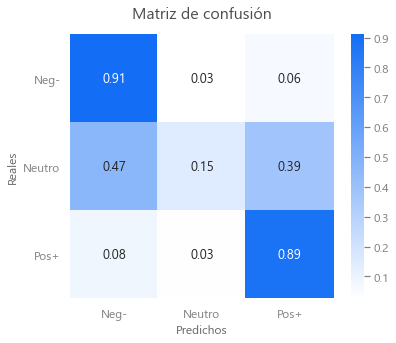

In [128]:
plt.figure(figsize=(6, 5))
conf_sent = confusion_matrix(y_test_tri, y_test_tri_pred_svc, 
                             labels=[0, 1, 2], 
                             normalize='true')
sns.heatmap(data = conf_sent, cbar=True, square=True, annot=True, 
            fmt= '.2f', annot_kws={'size': 13}, 
            xticklabels= ['Neg-', 'Neutro', 'Pos+'], 
            yticklabels=['Neg-', 'Neutro', 'Pos+'], 
            cmap=bluewhite)

plt.title('Matriz de confusión', pad=16)
plt.ylabel('Reales')
plt.xlabel('Predichos')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

Predecimos manteniendo solo 2 clases: negativo y postivo. Convertirmos las reviews con 3 estrellas en _negativo_.

In [129]:
def binarize_bi(x):
    if x == 4 or x == 5:
        return 1
    else:
        return 0
    
y_train_bi = train['stars'].apply(binarize_bi)
y_dev_bi = dev['stars'].apply(binarize_bi)
y_test_bi = test['stars'].apply(binarize_bi)

In [130]:
svc = LinearSVC(penalty='l2', dual=False, tol=1e-4, C=0.01)

svc.fit(X_train, y_train_bi)

y_train_bi_pred_svc = svc.predict(X_train)
y_dev_bi_pred_svc = svc.predict(X_dev)
y_test_bi_pred_svc = svc.predict(X_test)

print('Accuracy en el set de Train:', accuracy_score(y_train_bi, y_train_bi_pred_svc))
print('Accuracy en el set de Dev:', accuracy_score(y_dev_bi, y_dev_bi_pred_svc))
print('Accuracy en el set de Test:', accuracy_score(y_test_bi, y_test_bi_pred_svc), '<---')

Accuracy en el set de Train: 0.86784
Accuracy en el set de Dev: 0.8662
Accuracy en el set de Test: 0.8622 <---


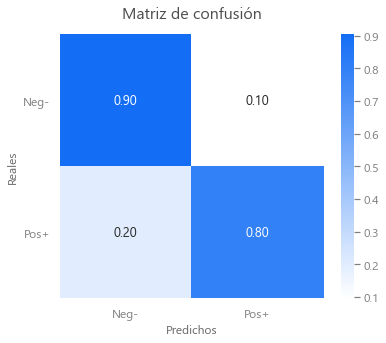

In [131]:
plt.figure(figsize=(6, 5))
conf_sent = confusion_matrix(y_test_bi, y_test_bi_pred_svc, 
                             labels=[0, 1], 
                             normalize='true')
sns.heatmap(data = conf_sent, cbar=True, square=True, annot=True, 
            fmt= '.2f', annot_kws={'size': 13}, 
            xticklabels= ['Neg-', 'Pos+'], 
            yticklabels=['Neg-', 'Pos+'], 
            cmap=bluewhite)

plt.title('Matriz de confusión', pad=16)
plt.ylabel('Reales')
plt.xlabel('Predichos')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

Como se evidencia en la prueba, manejar solo dos clases hace que el performance se incremente considerablemente.